# Import Libraries

In [46]:
!pip install -r requirements.txt -q

In [47]:
# Datahandling
import requests
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import numpy as np
import pandas as pd
import seaborn as sns

# Tweet Themes
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
import matplotlib.pyplot as plt
from bertopic import BERTopic
import plotly.express as px

# Network analysis
from typing import List, Optional
import json
import matplotlib.patches as mpatches
import networkx as nx
from community import community_louvain
import plotly.graph_objects as go
import random
from collections import defaultdict
import nbformat

# Model prediction
from setfit import SetFitModel, SetFitTrainer
from sklearn.metrics import classification_report
import tiktoken

# Gradio deployment
import gradio as gr


# Data

In [48]:
# Data import: 
data = pd.read_csv('TwitterData_Joined.csv')

In [49]:
data.head()

,Twitter_User_Name,Twitter_Account,Twitter_User_Description,Tweet_id,Tweet_created_at,Tweet_text,Label,Word_Count,Url_Count,Retweet,...,Adverb_Count,Positive_Word_Ratio,Negative_Word_Ratio,Neutral_Word_Ratio,Following,Followers,Verified,Link,Location,Real_Location
0,Museum Bot,MuseumBot,I am a bot that tweets a random high-res Open ...,8.027580e+17,27-11-2016 06:15,Imperial Theatrical Coat for Court Lady https:...,0,8,2,0,...,0,0.000,0.0,1.000,0,7816,0,https://twitter.com/MuseumBot?s=20,NaN,-1.0
1,Museum Bot,MuseumBot,I am a bot that tweets a random high-res Open ...,8.746920e+17,13-06-2017 18:15,Half-length Figure of St Paul in an Oval. http...,0,10,2,0,...,0,0.000,0.0,1.000,0,7816,0,https://twitter.com/MuseumBot?s=20,NaN,-1.0
2,Museum Bot,MuseumBot,I am a bot that tweets a random high-res Open ...,6.983900e+17,13-02-2016 06:15,Great Exhibition Jurors&amp;#39; Medal https:/...,0,6,2,0,...,0,0.125,0.0,0.875,0,7816,0,https://twitter.com/MuseumBot?s=20,NaN,-1.0
3,Museum Bot,MuseumBot,I am a bot that tweets a random high-res Open ...,6.976650e+17,11-02-2016 06:15,Pair of candelabra https://t.co/KYopSWDSw2 htt...,0,5,2,0,...,0,0.000,0.0,1.000,0,7816,0,https://twitter.com/MuseumBot?s=20,NaN,-1.0
4,Museum Bot,MuseumBot,I am a bot that tweets a random high-res Open ...,6.217450e+17,16-07-2015 18:15,Banner (Nobori)\n http://t.co/yz34Xgo9a5 http:...,0,4,2,0,...,0,0.000,0.0,1.000,0,7816,0,https://twitter.com/MuseumBot?s=20,NaN,-1.0


In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279691 entries, 0 to 279690
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Twitter_User_Name         279691 non-null  object 
 1   Twitter_Account           279691 non-null  object 
 2   Twitter_User_Description  276027 non-null  object 
 3   Tweet_id                  279691 non-null  float64
 4   Tweet_created_at          279691 non-null  object 
 5   Tweet_text                279691 non-null  object 
 6   Label                     279691 non-null  int64  
 7   Word_Count                279691 non-null  int64  
 8   Url_Count                 279691 non-null  int64  
 9   Retweet                   279691 non-null  int64  
 10  Original_User             58391 non-null   object 
 11  Mentions_Count            279691 non-null  int64  
 12  Hashtags_Count            279691 non-null  int64  
 13  QuesMark_Count            279691 non-null  i

# Network Analysis

In [51]:
# data sampling? 20000
data = pd.read_csv('TwitterData_Joined.csv')
data = data.sample(n=2000, random_state=42)

In [71]:
# Split the data based on the `label` column
data_label_0 = data[data['Label'] == 0]  # Subset where label=0
data_label_1 = data[data['Label'] == 1]  # Subset where label=1

# Optionally, check the sizes of the splits
print(f"Data with label=0: {len(data_label_0)} rows")
print(f"Data with label=1: {len(data_label_1)} rows")

Data with label=0: 950 rows
Data with label=1: 1050 rows


## LLM-processing

In [52]:
# LLM Libs & Setup
from openai import OpenAI
import json
from pydantic import BaseModel, Field
from typing import List, Optional
import textwrap

In [53]:
#IF YOU'RE USING COLAB, YOU CAN ACCESS GOOGLE COLAB SECRETS, provided you've stored your Together API Key there -
# - If that's the case?: Eliminate the #'s below and delete the following line: TOGETHER_API_KEY = "PLACE YOUR API KEY HERE"

# from google.colab import userdata
# TOGETHER_API_KEY = userdata.get('TOGETHER_API_KEY')

TOGETHER_API_KEY = "" # - REMOVE TEXT AND INPUT YOUR TOGETHER API KEY HERE

client = OpenAI(
    base_url="https://api.together.xyz/v1",
    api_key=TOGETHER_API_KEY
)

model = "meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo"

In [54]:
# Set your Together API Key directly
TOGETHER_API_KEY = "f7f98865262e753df89a8ac3b7bc474ff5eb2e86416e78550148a64d061e36ed"

# Check if the API key is set
if not TOGETHER_API_KEY:
    raise ValueError("The Together API Key must be provided.")

# Initialize the Together client
client = OpenAI(
    base_url="https://api.together.xyz/v1",
    api_key=TOGETHER_API_KEY
)

# Define the model
model = "meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo"

## SYSTEM_PROMPTS

In [55]:
SYSTEM_PROMPT = f"""
You are an advanced theme extraction assistant specializing in analyzing individual tweets. Your task is to extract thematic information, including primary themes, sub-themes, keywords, sentiment, and metadata, from a single tweet at a time. Your output must strictly adhere to the provided JSON schema.

Extraction Guidelines
Analyze the content of one tweet at a time to identify its primary theme .
Extract the following details for each tweet:
Theme : Identify the primary theme with supporting sub-themes and keywords.
Sentiment : Determine the emotional tone positive,negative,orneutral.
Metadata : Extract tweet-specific details like length, language, and whether it contains hashtags or mentions.
Ensure the analysis is granular and specific to the content of the individual tweet.
Output Requirements
Your output for each tweet must follow this structure:

Themes :
'name' : The main theme of the tweet.
'confidence' : A confidence level 0−100 indicating the strength of the theme's identification.
'sub_themes' : Any relevant sub-categories of the main theme.
'keywords' : Key terms or phrases that support the theme.
'sentiment' : The emotional tone of the tweet positive,negative,orneutral.
Metadata :
'tweet_length' : The character count of the tweet.
'language' : The detected language of the tweet.
'contains_hashtags' : Boolean indicating if the tweet includes hashtags.
'contains_mentions' : Boolean indicating if the tweet includes mentions.
Key Principles
Granularity and Focus : Restrict your analysis to the content of the current tweet without considering external context.
Precision and Objectivity : Ensure your output is specific to the tweet and free from assumptions or biases.
Consistency : Apply the same analytical framework to every tweet, ensuring uniformity across outputs.
Handling Ambiguity and Sentiment
If the theme or sentiment is ambiguous, indicate this through lower confidence scores and highlight relevant keywords for clarification.
Assign a neutral sentiment if no clear emotional tone is present.
Ethics and Objectivity
Ensure all outputs are derived solely from the provided tweet.
Respect data integrity and avoid introducing information not directly supported by the tweet content.
Output your findings in the predefined JSON schema format, strictly adhering to its structure for each tweet.
"""

In [56]:
json_schema = f"""
{{
    "type": "object",
    "properties": {{
        "themes": {{
            "type": "array",
            "items": {{
                "type": "object",
                "properties": {{
                    "name": {{
                        "type": "string",
                        "description": "Primary theme identified"
                    }},
                    "confidence": {{
                        "type": "number", 
                        "minimum": 0,
                        "maximum": 100,
                        "description": "Confidence level of theme extraction"
                    }},
                    "sub_themes": {{
                        "type": "array",
                        "items": {{"type": "string"}},
                        "description": "Specific sub-categories within the theme"
                    }},
                    "keywords": {{
                        "type": "array", 
                        "items": {{"type": "string"}},
                        "description": "Key terms supporting the theme"
                    }},
                    "sentiment": {{
                        "type": "string",
                        "enum": ["positive", "negative", "neutral"],
                        "description": "Emotional tone of the theme"
                    }}
                }},
                "required": ["name", "confidence"]
            }}
        }},
        "metadata": {{
            "type": "object",
            "properties": {{
                "tweet_length": {{"type": "integer"}},
                "language": {{"type": "string"}},
                "contains_hashtags": {{"type": "boolean"}},
                "contains_mentions": {{"type": "boolean"}}
            }}
        }}
    }},
    "required": ["themes"]
}}
"""

In [57]:
from pydantic import BaseModel, Field
from typing import List, Optional
class Theme(BaseModel):
    name: str = Field(description="Primary theme identified")
    confidence: float = Field(
        description="Confidence level of theme extraction", 
        ge=0, 
        le=100
    )
    sub_themes: Optional[List[str]] = Field(
        default=None,
        description="Specific sub-categories within the theme"
    )
    keywords: Optional[List[str]] = Field(
        default=None,
        description="Key terms supporting the theme"
    )
    sentiment: Optional[str] = Field(
        default=None,
        description="Emotional tone of the theme",
        pattern="^(positive|negative|neutral)$"
    )
class Metadata(BaseModel):
    tweet_length: Optional[int] = Field(
        default=None,
        description="Length of the tweet"
    )
    language: Optional[str] = Field(
        default=None, 
        description="Language of the tweet"
    )
    contains_hashtags: Optional[bool] = Field(
        default=None,
        description="Whether tweet contains hashtags"
    )
    contains_mentions: Optional[bool] = Field(
        default=None,
        description="Whether tweet contains mentions"
    )
class TweetAnalysis(BaseModel):
    themes: List[Theme]
    metadata: Optional[Metadata] = Field(
        default=None,
        description="Metadata about the tweet"
    )
    
# Dynamically generate the schema
json_schema = TweetAnalysis.model_json_schema()

## LLAMA3.1-8B BATCH PROCESSING

In [77]:
import tiktoken
import pandas as pd
import json
from openai import OpenAI
import concurrent.futures
import time
import queue
import threading
def rate_limited_executor(max_calls_per_minute=100):
    """
    Rate-limited executor til API-kald
    """
    # Opret en kø til at styre API-kald
    call_queue = queue.Queue()
    
    def worker():
        while True:
            # Hent næste kald fra køen
            func, args, kwargs, result_queue = call_queue.get()
            
            try:
                # Udfør API-kaldet
                result = func(*args, **kwargs)
                result_queue.put(result)
            except Exception as e:
                result_queue.put(e)
            
            # Markér opgave som færdig
            call_queue.task_done()
            
            # Begræns kald til maks 60 pr. minut
            time.sleep(0.5)  # 0.5 sekund mellem kald
    
    # Start worker tråde
    for _ in range(max_calls_per_minute):
        threading.Thread(target=worker, daemon=True).start()
    
    def submit(func, *args, **kwargs):
        # Opret resultat-kø
        result_queue = queue.Queue()
        
        # Indsæt kald i køen
        call_queue.put((func, args, kwargs, result_queue))
        
        # Vent på resultat
        result = result_queue.get()
        
        # Håndter eventuelle fejl
        if isinstance(result, Exception):
            raise result
        
        return result
    
    return submit
def process_large_batch_tweets(tweets, batch_size=10, executor=None):
    """
    Proces store batches af tweets med rate limiting
    """
    try:
        # Forbered beskeder til batch-processing
        messages = [
            {'role': 'system', 'content': SYSTEM_PROMPT},
            {'role': 'user', 'content': json.dumps(tweets)}
        ]
        
        # Brug executor til API-kald
        if executor:
            response = executor(
                client.chat.completions.create,
                model=model,
                messages=messages,
                temperature=0.7,
                response_format={"type": "json_object", "schema": json_schema},
                max_tokens=8192
            )
        else:
            # Standard API-kald uden rate limiting
            response = client.chat.completions.create(
                model=model,
                messages=messages,
                temperature=0.7,
                response_format={"type": "json_object", "schema": json_schema},
                max_tokens=8192
            )
        
        # Parse svaret
        processed_response = response.choices[0].message.content
        
        return {
            'batch_size': len(tweets),
            'processed_response': processed_response
        }
    
    except Exception as e:
        return {
            'batch_size': len(tweets),
            'error': str(e)
        }
    
def process_all_tweets_in_parallel(data, batch_size=10, max_workers=64):
    """
    Parallel processering af tweets med rate limiting
    """
    # Opret rate-limited executor
    executor = rate_limited_executor(max_calls_per_minute=60)
    
    processed_results = []
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as pool:
        # Forbered futures
        futures = []
        for i in range(0, len(data), batch_size):
            batch = data.iloc[i:i+batch_size]
            tweets = batch['Tweet_text'].tolist()
            
            # Send batch til parallel processering
            future = pool.submit(
                process_large_batch_tweets,
                tweets,
                batch_size,
                executor
            )
            futures.append(future)
            
            # Tilføj 0.1 sekunds pause mellem batches
            time.sleep(0.1)
        
        # Indsaml resultater løbende
        for future in concurrent.futures.as_completed(futures):
            result = future.result()
            processed_results.append(result)
    
    # Robust parsing og rensning af resultater
    def clean_and_parse_results(results):
        cleaned_results = []
        for result in results:
            try:
                # Fleksibel JSON-parsing
                if isinstance(result, str):
                    processed_response = json.loads(result)
                elif isinstance(result, dict):
                    # Prøv forskellige mulige nøgler
                    if 'processed_response' in result:
                        processed_response = json.loads(result['processed_response'])
                    elif 'response' in result:
                        processed_response = json.loads(result['response'])
                    else:
                        processed_response = result
                else:
                    processed_response = json.loads(json.dumps(result))
                
                # Opret nyt resultat-objekt med parsed data
                cleaned_result = {
                    'batch_size': result.get('batch_size', batch_size),
                    'themes': processed_response.get('themes', []),
                    'metadata': processed_response.get('metadata', {}),
                    'original_result': result  # Behold original data
                }
                
                cleaned_results.append(cleaned_result)
            
            except json.JSONDecodeError as e:
                print(f"JSON parsing fejl: {e}")
                print(f"Problematisk resultat: {result}")
            
            except Exception as e:
                print(f"Uventet fejl ved parsing: {e}")
        
        return cleaned_results
    
    # Rens resultaterne
    cleaned_results = clean_and_parse_results(processed_results)
    
    # Løbende gemning (hver 10. resultat)
    def safe_json_dump(data, filename):
        try:
            with open(filename, 'w', encoding='utf-8') as json_file:
                json.dump(data, json_file, 
                          ensure_ascii=False, 
                          indent=4, 
                          default=lambda o: str(o))
            print(f"Gemt {len(data)} resultater i {filename}")
        except Exception as e:
            print(f"Fejl ved JSON-gemning: {e}")
    
    # Gem midlertidige resultater
    if len(cleaned_results) % 10 == 0:
        safe_json_dump(cleaned_results, 'midlertidige_resultater.json')
    
    # Konverter til DataFrame
    result_df = pd.DataFrame(cleaned_results)
    
    # Gem endelige resultater
    safe_json_dump(cleaned_results, 'endelige_resultater.json')
    
    return result_df
# Brug funktionen
processed_tweets = process_all_tweets_in_parallel(
    data,
    batch_size=10,    # Batch størrelse
    max_workers=64    # Antal parallelle tråde
)

Gemt 200 resultater i midlertidige_resultater.json
Gemt 200 resultater i endelige_resultater.json


In [74]:
import tiktoken
import pandas as pd
import json
from openai import OpenAI
import concurrent.futures
import time
import queue
import threading


def rate_limited_executor(max_calls_per_minute=100):
    """ Rate-limited executor for API calls """
    # Create a queue to manage API calls
    call_queue = queue.Queue()


    def worker():
        while True:
            func, args, kwargs, result_queue = call_queue.get()
            try:
                # Execute the API call
                result = func(*args, **kwargs)
                result_queue.put(result)
            except Exception as e:
                result_queue.put(e)
            call_queue.task_done()
            # Limit calls to max 60 per minute
            time.sleep(0.5)  # 0.5 seconds between calls


    # Start worker threads
    for _ in range(max_calls_per_minute):
        threading.Thread(target=worker, daemon=True).start()


    def submit(func, *args, **kwargs):
        # Create result queue
        result_queue = queue.Queue()
        # Put call in the queue
        call_queue.put((func, args, kwargs, result_queue))
        # Wait for result
        result = result_queue.get()
        # Handle any errors
        if isinstance(result, Exception):
            raise result
        return result


    return submit


def process_large_batch_tweets(tweets, batch_size=10, executor=None):
    """ Process large batches of tweets with rate limiting """
    try:
        # Prepare messages for batch-processing
        messages = [
            {'role': 'system', 'content': SYSTEM_PROMPT},
            {'role': 'user', 'content': json.dumps(tweets)}
        ]


        # Use executor for API calls
        if executor:
            response = executor(
                client.chat.completions.create,
                model=model,
                messages=messages,
                temperature=0.7,
                response_format={"type": "json object"},
                schema=json_schema,
                max_tokens=8192
            )
        else:
            # Standard API call without rate limiting
            response = client.chat.completions.create(
                model=model,
                messages=messages,
                temperature=0.7,
                response_format={"type": "json object"},
                schema=json_schema,
                max_tokens=8192
            )


        # Parse the response
        processed_response = response.choices[0].message.content
        return {'batch_size': len(tweets), 'processed_response': processed_response}
    except Exception as e:
        return {'batch_size': len(tweets), 'error': str(e)}


def process_all_tweets_in_parallel(data, batch_size=10, max_workers=64):
    """ Parallel processing of tweets with rate limiting """
    # Create rate-limited executor
    executor = rate_limited_executor(max_calls_per_minute=60)
    processed_results = []


    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as pool:
        # Prepare futures
        futures = []
        for i in range(0, len(data), batch_size):
            batch = data.iloc[i:i + batch_size]
            tweets = batch['Tweet_text'].tolist()
            # Send batch for parallel processing
            future = pool.submit(process_large_batch_tweets, tweets, batch_size, executor)
            futures.append(future)
            # Add a 0.1 second pause between batches
            time.sleep(0.1)


        # Collect results as they complete
        for future in concurrent.futures.as_completed(futures):
            result = future.result()
            processed_results.append(result)


    # Robust parsing and cleaning of results
    def clean_and_parse_results(results):
        cleaned_results = []
        for result in results:
            try:
                # Flexible JSON parsing
                if isinstance(result, str):
                    processed_response = json.loads(result)
                elif isinstance(result, dict):
                    if 'processed_response' in result:
                        processed_response = json.loads(result['processed_response'])
                    elif 'response' in result:
                        processed_response = json.loads(result['response'])
                    else:
                        processed_response = result
                else:
                    processed_response = json.loads(json.dumps(result))


                # Create new result object with parsed data
                cleaned_result = {
                    'batch_size': result.get('batch_size', batch_size),
                    'themes': processed_response.get('themes', []),
                    'metadata': processed_response.get('metadata', {}),
                    'original_result': result  # Keep original data
                }
                cleaned_results.append(cleaned_result)
            except json.JSONDecodeError as e:
                print(f"JSON parsing error: {e}")
                print(f"Problematic result: {result}")
            except Exception as e:
                print(f"Unexpected error during parsing: {e}")


        return cleaned_results


    # Clean the results
    cleaned_results = clean_and_parse_results(processed_results)


    # Periodic saving (every 10 results)
    def safe_json_dump(data, filename):
        try:
            with open(filename, 'w', encoding='utf-8') as json_file:
                json.dump(data, json_file, ensure_ascii=False, indent=4, default=lambda o: str(o))
            print(f"Saved {len(data)} results to {filename}")
        except Exception as e:
            print(f"Error during JSON saving: {e}")


    # Save temporary results
    if len(cleaned_results) % 10 == 0:
        safe_json_dump(cleaned_results, 'temporary_results.json')


    # Convert to DataFrame
    result_df = pd.DataFrame(cleaned_results)


    # Save final results
    safe_json_dump(cleaned_results, 'label_0.json')
    return result_df


# Assuming 'data' is your original DataFrame
data_label_0 = data[data['Label'] == 0]  # Subset where label=0


# Use the function with the subset of data
processed_tweets = process_all_tweets_in_parallel(
    data_label_0,
    batch_size=10,  # Batch size
    max_workers=64  # Number of parallel threads
)

Saved 95 results to label_0.json


## V2 TEST?? 

In [81]:
schema = json_schema

In [82]:
import tiktoken
import pandas as pd
import json
import time
from concurrent.futures import ThreadPoolExecutor
from queue import Queue

def rate_limited_executor(max_calls_per_minute=100):
    """
    Rate-limited executor til API-kald.
    """
    call_queue = Queue()

    def worker():
        while True:
            func, args, kwargs, result_queue = call_queue.get()
            try:
                result_queue.put(func(*args, **kwargs))
            except Exception as e:
                result_queue.put(e)
            call_queue.task_done()
            time.sleep(60 / max_calls_per_minute)

    for _ in range(max_calls_per_minute):
        threading.Thread(target=worker, daemon=True).start()

    def submit(func, *args, **kwargs):
        result_queue = Queue()
        call_queue.put((func, args, kwargs, result_queue))
        result = result_queue.get()
        if isinstance(result, Exception):
            raise result
        return result

    return submit

def process_batch(tweets, executor, model, schema, batch_size):
    """
    Proces én batch af tweets.
    """
    messages = [
        {'role': 'system', 'content': SYSTEM_PROMPT},
        {'role': 'user', 'content': json.dumps(tweets)}
    ]
    try:
        response = executor(
            client.chat.completions.create,
            model=model,
            messages=messages,
            temperature=0.7,
            response_format={"type": "json_object", "schema": schema},
            max_tokens=8192
        )
        return {'batch_size': len(tweets), 'response': response.choices[0].message.content}
    except Exception as e:
        return {'batch_size': len(tweets), 'error': str(e)}

def parallel_process_tweets(data, batch_size, max_workers, model, schema):
    """
    Parallel processering af tweets med rate-limiting.
    """
    executor = rate_limited_executor(max_calls_per_minute=60)
    results = []

    def process_and_collect(batch):
        tweets = batch['Tweet_text'].tolist()
        return process_batch(tweets, executor, model, schema, batch_size)

    with ThreadPoolExecutor(max_workers=max_workers) as pool:
        batches = [data.iloc[i:i + batch_size] for i in range(0, len(data), batch_size)]
        futures = [pool.submit(process_and_collect, batch) for batch in batches]
        for future in futures:
            results.append(future.result())

    return pd.DataFrame(results)

def save_results(data, filename):
    """
    Gem data til JSON-fil.
    """
    try:
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(data, f, ensure_ascii=False, indent=4)
        print(f"Resultater gemt i {filename}")
    except Exception as e:
        print(f"Fejl ved gemning: {e}")

# Brug funktionen
processed_tweets = parallel_process_tweets(
    data=data,
    batch_size=10,
    max_workers=64,
    model=model,
    schema=json_schema
)
save_results(processed_tweets.to_dict(orient="records"), "endelige_resultater.json")

Resultater gemt i endelige_resultater.json


In [85]:
import tiktoken
import pandas as pd
import json
import time
from concurrent.futures import ThreadPoolExecutor
from queue import Queue
import threading


def rate_limited_executor(max_calls_per_minute=100):
    """Rate-limited executor for API calls."""
    call_queue = Queue()


    def worker():
        while True:
            func, args, kwargs, result_queue = call_queue.get()
            try:
                result_queue.put(func(*args, **kwargs))
            except Exception as e:
                result_queue.put(e)
            call_queue.task_done()
            time.sleep(60 / max_calls_per_minute)


    for _ in range(max_calls_per_minute):
        threading.Thread(target=worker, daemon=True).start()


    def submit(func, *args, **kwargs):
        result_queue = Queue()
        call_queue.put((func, args, kwargs, result_queue))
        result = result_queue.get()
        if isinstance(result, Exception):
            raise result
        return result


    return submit


def process_batch(tweets, executor, model, schema, batch_size):
    """Process one batch of tweets."""
    messages = [
        {'role': 'system', 'content': SYSTEM_PROMPT},
        {'role': 'user', 'content': json.dumps(tweets)}
    ]
    try:
        response = executor(
            client.chat.completions.create,
            model=model,
            messages=messages,
            temperature=0.7,
            response_format={"type": "json_object", "schema": schema},
            max_tokens=8192
        )
        return {'batch_size': len(tweets), 'response': response.choices[0].message.content}
    except Exception as e:
        return {'batch_size': len(tweets), 'error': str(e)}


def parallel_process_tweets(data, batch_size, max_workers, model, schema):
    """Parallel processing of tweets with rate-limiting."""
    executor = rate_limited_executor(max_calls_per_minute=60)
    results = []


    def process_and_collect(batch):
        tweets = batch['Tweet_text'].tolist()
        return process_batch(tweets, executor, model, schema, batch_size)


    with ThreadPoolExecutor(max_workers=max_workers) as pool:
        batches = [data.iloc[i:i + batch_size] for i in range(0, len(data), batch_size)]
        futures = [pool.submit(process_and_collect, batch) for batch in batches]
        for future in futures:
            results.append(future.result())


    return pd.DataFrame(results)


def save_results(data, filename):
    """Save data to JSON file."""
    try:
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(data, f, ensure_ascii=False, indent=4)
        print(f"Results saved in {filename}")
    except Exception as e:
        print(f"Error during saving: {e}")


# Assuming 'data_label_0' is your DataFrame filtered for label 0
processed_tweets = parallel_process_tweets(
    data=data_label_0,  # Use the data_label_0 DataFrame
    batch_size=10,      # Batch size
    max_workers=64,     # Number of parallel threads
    model=model,        # Your model variable
    schema=json_schema  # Your JSON schema variable
)


# Save the results to label_0.json
save_results(processed_tweets.to_dict(orient="records"), "label_0.json")

Results saved in label_0.json


In [83]:
import json

# Filsti til JSON-filen
file_path = 'endelige_resultater.json'

# Forsøger at indlæse JSON-filen
try:
    with open(file_path, 'r', encoding='utf-8') as file:
        data_json = json.load(file)

    # Eksempel på struktur af data (første element)
    example_entry = data_json[0] if isinstance(data_json, list) and len(data_json) > 0 else None
    load_status = "JSON-filen blev indlæst succesfuldt."
except Exception as e:
    data_json = None
    example_entry = None
    load_status = f"Fejl ved indlæsning af JSON-filen: {e}"

load_status, type(data_json), example_entry

('JSON-filen blev indlæst succesfuldt.',
 list,
 {'batch_size': 10,
  'response': '{"themes" :[{"name" : "Traffic Update", "confidence" : 90, "sub_themes" : ["Road Conditions", "Traffic Incident"], "keywords" : ["ramps", "scene cleared"], "sentiment" : "neutral"}, {"name" : "Religious Ideology", "confidence" : 80, "sub_themes" : ["Peaceful Religion", "Islamic Teachings"], "keywords" : ["religion of peace"], "sentiment" : "positive"}, {"name" : "Coffee Culture", "confidence" : 75, "sub_themes" : ["Coffee Enthusiasm", "Pour Over"], "keywords" : ["pour over", "coffee"], "sentiment" : "neutral"}, {"name" : "Programming Debate", "confidence" : 85, "sub_themes" : ["VHDL vs Verilog", "Programming Languages"], "keywords" : ["VHDL", "Verilog"], "sentiment" : "neutral"}, {"name" : "Bitcoin Market", "confidence" : 95, "sub_themes" : ["Bitcoin Investment", "Financial News"], "keywords" : ["bitcoin", "bullish"], "sentiment" : "positive"}, {"name" : "Social Media Praise", "confidence" : 90, "sub_the

In [86]:
import json  # Importing the JSON module


# File path for the JSON file
file_path = 'label_0.json'  # Updated to load from label_0.json


# Trying to load the JSON file
try:
    with open(file_path, 'r', encoding='utf-8') as file:
        data_json = json.load(file)


    # Example of the structure of data (first element)
    example_entry = data_json[0] if isinstance(data_json, list) and len(data_json) > 0 else None
    load_status = "JSON file loaded successfully."
except Exception as e:
    data_json = None
    example_entry = None
    load_status = f"Error loading JSON file: {e}"


# Output the loading status, type of data_json, and example entry
load_status, type(data_json), example_entry

('JSON file loaded successfully.',
 list,
 {'batch_size': 10,
  'response': '{"themes": [{"name": "Programming", "confidence": 90, "sub_themes": ["VHDL", "Verilog", "hardware description languages"], "keywords": ["VHDL", "Verilog"], "sentiment": "neutral"}, {"name": "Bitcoin", "confidence": 95, "sub_themes": ["Winklevoss", "Gemini", "NYSE CIO"], "keywords": ["bitcoin", "Winklevoss", "Gemini", "NYSE CIO"], "sentiment": "positive"}], "metadata": {"tweet_length": 72, "language": "en", "contains_hashtags": false, "contains_mentions": false}}',
  'error': nan})

In [84]:
def visualize_with_plotly(G):
    # Positioner for noder
    pos = nx.spring_layout(G, seed=42)  # Fix layout for konsistent visualisering
    
    # Adskil noder efter type
    theme_nodes = [node for node, data in G.nodes(data=True) if data.get('type') == 'theme']
    subtheme_nodes = [node for node, data in G.nodes(data=True) if data.get('type') == 'sub_theme']
    
    # Opdel kanter
    edges = list(G.edges())
    
    # Lav edge trace
    edge_x = []
    edge_y = []
    for edge in edges:
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
    
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines'
    )
    
    # Lav node trace for themes
    theme_x = [pos[node][0] for node in theme_nodes]
    theme_y = [pos[node][1] for node in theme_nodes]
    
    theme_trace = go.Scatter(
        x=theme_x, y=theme_y,
        mode='markers+text',
        text=theme_nodes,
        textposition="top center",
        marker=dict(
            size=15,
            color='red',
            line=dict(width=2, color='black')
        ),
        name='Themes'
    )
    
    # Lav node trace for subthemes
    subtheme_x = [pos[node][0] for node in subtheme_nodes]
    subtheme_y = [pos[node][1] for node in subtheme_nodes]
    
    subtheme_trace = go.Scatter(
        x=subtheme_x, y=subtheme_y,
        mode='markers+text',
        text=subtheme_nodes,
        textposition="top center",
        marker=dict(
            size=10,
            color='blue',
            line=dict(width=1, color='black')
        ),
        name='Sub-Themes'
    )
    
    # Saml traces i figuren
    fig = go.Figure(data=[edge_trace, theme_trace, subtheme_trace],
                    layout=go.Layout(
                        title="Simplificeret Netværk: Themes og Sub-Themes",
                        showlegend=True,
                        hovermode='closest',
                        margin=dict(b=0, l=0, r=0, t=40),
                        xaxis=dict(showgrid=False, zeroline=False),
                        yaxis=dict(showgrid=False, zeroline=False)
                    ))
    fig.show()

# Lav netværk baseret på themes og sub-themes
theme_subtheme_network = create_theme_subtheme_network(data_json)

# Visualiser netværket med Plotly
visualize_with_plotly(theme_subtheme_network)

In [88]:
import json
import networkx as nx
import plotly.graph_objs as go




# Load the JSON file
file_path = 'label_0.json'
try:
    with open(file_path, 'r', encoding='utf-8') as file:
        data_json = json.load(file)
except Exception as e:
    print(f"Error loading JSON file: {e}")
    data_json = []




def create_theme_subtheme_network(data):
    """
    Create a network graph from themes and sub-themes
    """
    G = nx.Graph()
    
    # Process each entry in the data
    for entry in data:
        try:
            # Check if entry is a dictionary and has a 'response' key
            if isinstance(entry, dict) and 'response' in entry:
                # Try parsing the response
                response = entry['response']
                
                # If response is a string, try to parse it as JSON
                if isinstance(response, str):
                    try:
                        response = json.loads(response)
                    except json.JSONDecodeError:
                        print(f"Could not parse response: {response}")
                        continue
                
                # If response is already a dictionary
                if isinstance(response, dict):
                    # Check for themes
                    if 'themes' in response:
                        for theme in response['themes']:
                            # Ensure theme is a dictionary
                            if isinstance(theme, dict):
                                theme_name = theme.get('name', 'Unknown Theme')
                                
                                # Add theme node
                                G.add_node(theme_name, type='theme')
                                
                                # Add sub-themes and connections
                                if 'sub_themes' in theme and isinstance(theme['sub_themes'], list):
                                    for sub_theme in theme['sub_themes']:
                                        # Add sub-theme node
                                        G.add_node(sub_theme, type='sub_theme')
                                        
                                        # Connect theme to sub-theme
                                        G.add_edge(theme_name, sub_theme)
        
        except Exception as e:
            print(f"Error processing entry: {e}")
    
    return G




def visualize_with_plotly(G):
    """
    Visualize the network using Plotly
    """
    # Only proceed if the graph is not empty
    if len(G.nodes) == 0:
        print("The graph is empty. Cannot visualize.")
        return
    
    # Positions for nodes
    pos = nx.spring_layout(G, seed=42)  # Fix layout for consistent visualization
    
    # Separate nodes by type
    theme_nodes = [node for node, data in G.nodes(data=True) if data.get('type') == 'theme']
    subtheme_nodes = [node for node, data in G.nodes(data=True) if data.get('type') == 'sub_theme']
    
    # Prepare edges
    edges = list(G.edges())
    
    # Create edge trace
    edge_x = []
    edge_y = []
    for edge in edges:
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
    
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines'
    )
    
    # Create node trace for themes
    theme_x = [pos[node][0] for node in theme_nodes]
    theme_y = [pos[node][1] for node in theme_nodes]
    
    theme_trace = go.Scatter(
        x=theme_x, y=theme_y,
        mode='markers+text',
        text=theme_nodes,
        textposition="top center",
        marker=dict(
            size=15,
            color='red',
            line=dict(width=2, color='black')
        ),
        name='Themes'
    )
    
    # Create node trace for sub-themes
    subtheme_x = [pos[node][0] for node in subtheme_nodes]
    subtheme_y = [pos[node][1] for node in subtheme_nodes]
    
    subtheme_trace = go.Scatter(
        x=subtheme_x, y=subtheme_y,
        mode='markers+text',
        text=subtheme_nodes,
        textposition="top center",
        marker=dict(
            size=10,
            color='blue',
            line=dict(width=1, color='black')
        ),
        name='Sub-Themes'
    )
    
    # Combine traces in the figure
    fig = go.Figure(data=[edge_trace, theme_trace, subtheme_trace],
                    layout=go.Layout(
                        title="Simplified Network: Themes and Sub-Themes",
                        showlegend=True,
                        hovermode='closest',
                        margin=dict(b=0, l=0, r=0, t=40),
                        xaxis=dict(showgrid=False, zeroline=False),
                        yaxis=dict(showgrid=False, zeroline=False)
                    ))
    fig.show()




# Create network based on themes and sub-themes
theme_subtheme_network = create_theme_subtheme_network(data_json)




# Visualize the network with Plotly
visualize_with_plotly(theme_subtheme_network)

In [68]:
import networkx as nx
import plotly.graph_objects as go
def create_theme_subtheme_network(data_json):
    G = nx.Graph()
    
    for item in data_json:
        response = item.get('response')
        if isinstance(response, str):
            try:
                response_data = json.loads(response)
                themes = response_data.get('themes', [])
                
                for theme in themes:
                    theme_name = theme['name']
                    sub_themes = theme.get('sub_themes', [])
                    
                    # Tilføj tema-node
                    G.add_node(theme_name, 
                               type='theme', 
                               confidence=theme.get('confidence', 0),
                               sentiment=theme.get('sentiment', 'neutral'))
                    
                    # Forbind tema til undertemaer
                    for sub_theme in sub_themes:
                        G.add_node(sub_theme, type='sub_theme')
                        G.add_edge(theme_name, sub_theme)
            
            except json.JSONDecodeError:
                print(f"Advarsel: Ugyldigt JSON-format")
    
    return G
def plotly_theme_network(G):
    # Forbered node-data
    node_x = []
    node_y = []
    node_text = []
    node_color = []
    node_size = []
    # Layout
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    
    # Generer node-positioner og egenskaber
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        
        # Tekst og farve baseret på node-type
        if G.nodes[node].get('type') == 'theme':
            node_text.append(f"Theme: {node}<br>Confidence: {G.nodes[node].get('confidence', 'N/A')}<br>Sentiment: {G.nodes[node].get('sentiment', 'N/A')}")
            node_color.append('red')
            node_size.append(20)
        else:
            node_text.append(f"Sub-theme: {node}")
            node_color.append('blue')
            node_size.append(10)
    # Forbered kant-data
    edge_x = []
    edge_y = []
    for edge in G.edges():
        start_x, start_y = pos[edge[0]]
        end_x, end_y = pos[edge[1]]
        edge_x.extend([start_x, end_x, None])
        edge_y.extend([start_y, end_y, None])
    # Opret Plotly figur
    fig = go.Figure()
    # Tilføj kanter
    fig.add_trace(go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines'))
    # Tilføj noder
    fig.add_trace(go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        hovertext=node_text,
        marker=dict(
            showscale=False,
            colorscale='Viridis',
            color=node_color,
            size=node_size,
            line_width=2
        ),
        text=[node for node in G.nodes()],
        textposition='top center'
    ))
    # Layout indstillinger
    fig.update_layout(
        title='Tema og Undertema Netværk',
        titlefont_size=16,
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20,l=5,r=5,t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )
    return fig
# Brug eksempel
theme_network = create_theme_subtheme_network(data_json)
fig = plotly_theme_network(theme_network)
fig.show()
# Tilføg nogle netværksanalyse funktioner
def network_analysis(G):
    print("Netværksstatistikker:")
    print(f"Antal noder: {G.number_of_nodes()}")
    print(f"Antal kanter: {G.number_of_edges()}")
    
    # Themes centrality
    theme_nodes = [node for node, data in G.nodes(data=True) if data.get('type') == 'theme']
    degree_centrality = nx.degree_centrality(G)
    top_central_themes = sorted(
        [(node, degree_centrality[node]) for node in theme_nodes], 
        key=lambda x: x[1], 
        reverse=True
    )[:5]
    
    print("\nTop 5 centrale temaer:")
    for theme, centrality in top_central_themes:
        print(f"{theme}: {centrality}")
    
    # Sentiment fordeling
    sentiments = [data.get('sentiment', 'neutral') for node, data in G.nodes(data=True) if data.get('type') == 'theme']
    sentiment_count = {
        'positive': sentiments.count('positive'),
        'negative': sentiments.count('negative'),
        'neutral': sentiments.count('neutral')
    }
    print("\nSentiment fordeling:")
    print(sentiment_count)
# Udfør netværksanalyse
network_analysis(theme_network)

Netværksstatistikker:
Antal noder: 1825
Antal kanter: 1773

Top 5 centrale temaer:
Politics: 0.046600877192982455
Technology: 0.02576754385964912
Music: 0.023026315789473683
Social Media: 0.019736842105263157
Humor: 0.016995614035087717

Sentiment fordeling:
{'positive': 154, 'negative': 92, 'neutral': 271}


In [66]:
import networkx as nx
import plotly.graph_objects as go
def create_theme_subtheme_network(data_json, min_confidence=90):
    # Graf til netværksanalyse
    G = nx.Graph()
    
    for item in data_json:
        response = item.get('response')
        if isinstance(response, str):
            try:
                response_data = json.loads(response)
                themes = response_data.get('themes', [])
                
                for theme in themes:
                    # Tjek confidence-niveau
                    confidence = theme.get('confidence', 0)
                    if confidence >= min_confidence:
                        theme_name = theme['name']
                        sub_themes = theme.get('sub_themes', [])
                        
                        # Tilføj tema-node
                        G.add_node(theme_name, type='theme')
                        
                        # Tilføj under-temaer og forbind til temaet
                        for sub_theme in sub_themes:
                            G.add_node(sub_theme, type='sub_theme')
                            G.add_edge(theme_name, sub_theme)
            
            except json.JSONDecodeError:
                print(f"Ugyldig JSON i response: {response}")
    
    return G
def visualize_with_plotly(G):
    # Positioner for noder
    pos = nx.spring_layout(G, seed=42)  # Konsistent layout
    
    # Adskil noder efter type
    theme_nodes = [node for node, data in G.nodes(data=True) if data.get('type') == 'theme']
    subtheme_nodes = [node for node, data in G.nodes(data=True) if data.get('type') == 'sub_theme']
    
    # Kanter
    edges = list(G.edges())
    
    # Edge trace
    edge_x, edge_y = [], []
    for edge in edges:
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
    
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=1, color='lightgrey'),
        hoverinfo='none',
        mode='lines'
    )
    
    # Theme nodes trace
    theme_x = [pos[node][0] for node in theme_nodes]
    theme_y = [pos[node][1] for node in theme_nodes]
    
    theme_trace = go.Scatter(
        x=theme_x, y=theme_y,
        mode='markers+text',
        text=theme_nodes,
        textposition="top center",
        marker=dict(
            size=20,  # Lidt større
            color='red',
            line=dict(width=2, color='darkred')
        ),
        name='Themes'
    )
    
    # Sub-theme nodes trace
    subtheme_x = [pos[node][0] for node in subtheme_nodes]
    subtheme_y = [pos[node][1] for node in subtheme_nodes]
    
    subtheme_trace = go.Scatter(
        x=subtheme_x, y=subtheme_y,
        mode='markers+text',
        text=subtheme_nodes,
        textposition="bottom center",
        marker=dict(
            size=12,
            color='blue',
            line=dict(width=1, color='darkblue')
        ),
        name='Sub-Themes'
    )
    
    # Samle figur
    fig = go.Figure(data=[edge_trace, theme_trace, subtheme_trace],
                    layout=go.Layout(
                        title="Tema-netværk (Confidence ≥ 90%)",
                        showlegend=True,
                        hovermode='closest',
                        margin=dict(b=20, l=20, r=20, t=40),
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                    ))
    
    # Tilpas layout for bedre læsbarhed
    fig.update_layout(
        plot_bgcolor='white',
        paper_bgcolor='white'
    )
    
    fig.show()
# Opret og visualiser netværk
high_confidence_network = create_theme_subtheme_network(data_json, min_confidence=90)
visualize_with_plotly(high_confidence_network)

In [70]:
import networkx as nx
import plotly.graph_objects as go
import pandas as pd
def create_theme_subtheme_network(data_json, min_confidence=90):
    # Graf til netværksanalyse
    G = nx.Graph()
    
    for item in data_json:
        response = item.get('response')
        if isinstance(response, str):
            try:
                response_data = json.loads(response)
                themes = response_data.get('themes', [])
                
                for theme in themes:
                    # Tjek confidence-niveau
                    confidence = theme.get('confidence', 0)
                    if confidence >= min_confidence:
                        theme_name = theme['name']
                        sub_themes = theme.get('sub_themes', [])
                        
                        # Tilføj tema-node
                        G.add_node(theme_name, type='theme')
                        
                        # Tilføj under-temaer og forbind til temaet
                        for sub_theme in sub_themes:
                            G.add_node(sub_theme, type='sub_theme')
                            G.add_edge(theme_name, sub_theme)
            
            except json.JSONDecodeError:
                print(f"Ugyldig JSON i response: {response}")
    
    return G
def calculate_network_metrics(G):
    # Beregn centrale netværksmetrikker
    metrics = {}
    
    # Degree Centrality
    degree_centrality = nx.degree_centrality(G)
    
    # Eigenvector Centrality
    try:
        eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=300)
    except nx.PowerIterationFailedConvergence:
        # Fallback til approksimativ metode
        eigenvector_centrality = {node: 0 for node in G.nodes()}
    
    # Betweenness Centrality
    betweenness_centrality = nx.betweenness_centrality(G)
    
    # Saml metrikker
    for node in G.nodes():
        metrics[node] = {
            'degree_centrality': degree_centrality.get(node, 0),
            'eigenvector_centrality': eigenvector_centrality.get(node, 0),
            'betweenness_centrality': betweenness_centrality.get(node, 0)
        }
    
    return metrics
def visualize_with_plotly(G, metrics):
    # Positioner for noder
    pos = nx.spring_layout(G, seed=42)  # Konsistent layout
    
    # Adskil noder efter type
    theme_nodes = [node for node, data in G.nodes(data=True) if data.get('type') == 'theme']
    subtheme_nodes = [node for node, data in G.nodes(data=True) if data.get('type') == 'sub_theme']
    
    # Kanter
    edges = list(G.edges())
    
    # Edge trace
    edge_x, edge_y = [], []
    for edge in edges:
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
    
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=1, color='lightgrey'),
        hoverinfo='none',
        mode='lines'
    )
    
    # Forbered hover-tekst med metrikker
    def create_hover_text(node):
        node_metrics = metrics[node]
        return (f"Node: {node}<br>"
                f"Degree Centrality: {node_metrics['degree_centrality']:.4f}<br>"
                f"Eigenvector Centrality: {node_metrics['eigenvector_centrality']:.4f}<br>"
                f"Betweenness Centrality: {node_metrics['betweenness_centrality']:.4f}")
    
    # Theme nodes trace
    theme_x = [pos[node][0] for node in theme_nodes]
    theme_y = [pos[node][1] for node in theme_nodes]
    theme_sizes = [20 + (metrics[node]['degree_centrality'] * 50) for node in theme_nodes]
    theme_hover_texts = [create_hover_text(node) for node in theme_nodes]
    
    theme_trace = go.Scatter(
        x=theme_x, y=theme_y,
        mode='markers+text',
        text=theme_nodes,
        textposition="top center",
        marker=dict(
            size=theme_sizes,
            color='red',
            line=dict(width=2, color='darkred'),
            opacity=0.7
        ),
        hovertext=theme_hover_texts,
        hoverinfo='text',
        name='Themes'
    )
    
    # Sub-theme nodes trace
    subtheme_x = [pos[node][0] for node in subtheme_nodes]
    subtheme_y = [pos[node][1] for node in subtheme_nodes]
    subtheme_sizes = [10 + (metrics[node]['degree_centrality'] * 30) for node in subtheme_nodes]
    subtheme_hover_texts = [create_hover_text(node) for node in subtheme_nodes]
    
    subtheme_trace = go.Scatter(
        x=subtheme_x, y=subtheme_y,
        mode='markers+text',
        text=subtheme_nodes,
        textposition="bottom center",
        marker=dict(
            size=subtheme_sizes,
            color='blue',
            line=dict(width=1, color='darkblue'),
            opacity=0.7
        ),
        hovertext=subtheme_hover_texts,
        hoverinfo='text',
        name='Sub-Themes'
    )
    
    # Saml figur
    fig = go.Figure(data=[edge_trace, theme_trace, subtheme_trace],
                    layout=go.Layout(
                        title="Tema-netværk med Centralitetsmetrikker",
                        showlegend=True,
                        hovermode='closest',
                        margin=dict(b=20, l=20, r=20, t=40),
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                    ))
    
    fig.update_layout(
        plot_bgcolor='white',
        paper_bgcolor='white'
    )
    
    fig.show()
    
    return metrics
# Opret netværk og beregn metrikker
high_confidence_network = create_theme_subtheme_network(data_json, min_confidence=90)
network_metrics = calculate_network_metrics(high_confidence_network)
# Visualiser netværk
visualized_metrics = visualize_with_plotly(high_confidence_network, network_metrics)

In [69]:
def generate_network_metrics_report(metrics_df):
    # Sorter efter forskellige centralitetsmetrikker
    print("\n--- Netværksanalyse Rapport ---")
    
    # Eigenvector Centrality Top 5
    print("\n🌟 Top 5 Nodes - Eigenvector Centrality:")
    eigenvector_sorted = metrics_df.sort_values('eigenvector_centrality', ascending=False).head(5)
    for _, row in eigenvector_sorted.iterrows():
        print(f"Node: {row['Node']}, Eigenvector Centrality: {row['eigenvector_centrality']:.4f}")
    
    # Degree Centrality Top 5
    print("\n🔗 Top 5 Nodes - Degree Centrality:")
    degree_sorted = metrics_df.sort_values('degree_centrality', ascending=False).head(5)
    for _, row in degree_sorted.iterrows():
        print(f"Node: {row['Node']}, Degree Centrality: {row['degree_centrality']:.4f}")
    
    # Betweenness Centrality Top 5
    print("\n🌉 Top 5 Nodes - Betweenness Centrality:")
    betweenness_sorted = metrics_df.sort_values('betweenness_centrality', ascending=False).head(5)
    for _, row in betweenness_sorted.iterrows():
        print(f"Node: {row['Node']}, Betweenness Centrality: {row['betweenness_centrality']:.4f}")
    
    # Samlet statistisk oversigt
    print("\n📊 Overordnet Netværksstatistik:")
    print(f"Totalt antal noder: {len(metrics_df)}")
    print(f"Gennemsnitlig Eigenvector Centrality: {metrics_df['eigenvector_centrality'].mean():.4f}")
    print(f"Gennemsnitlig Degree Centrality: {metrics_df['degree_centrality'].mean():.4f}")
    print(f"Gennemsnitlig Betweenness Centrality: {metrics_df['betweenness_centrality'].mean():.4f}")
# Tilføj denne del efter visualiseringen
metrics_df = pd.DataFrame.from_dict(network_metrics, orient='index')
metrics_df.index.name = 'Node'
metrics_df.reset_index(inplace=True)
# Generer detaljeret rapport
generate_network_metrics_report(metrics_df)


--- Netværksanalyse Rapport ---

🌟 Top 5 Nodes - Eigenvector Centrality:
Node: Politics, Eigenvector Centrality: 0.7302
Node: Politics/Leadership, Eigenvector Centrality: 0.1495
Node: Leadership, Eigenvector Centrality: 0.1428
Node: Security, Eigenvector Centrality: 0.1288
Node: London, Eigenvector Centrality: 0.1255

🔗 Top 5 Nodes - Degree Centrality:
Node: Politics, Degree Centrality: 0.0514
Node: Music, Degree Centrality: 0.0389
Node: Entertainment, Degree Centrality: 0.0296
Node: Humor, Degree Centrality: 0.0265
Node: Technology, Degree Centrality: 0.0234

🌉 Top 5 Nodes - Betweenness Centrality:
Node: Humor, Betweenness Centrality: 0.0551
Node: Conversation, Betweenness Centrality: 0.0435
Node: Chit-chat, Betweenness Centrality: 0.0399
Node: Music, Betweenness Centrality: 0.0370
Node: Entertainment, Betweenness Centrality: 0.0368

📊 Overordnet Netværksstatistik:
Totalt antal noder: 643
Gennemsnitlig Eigenvector Centrality: 0.0076
Gennemsnitlig Degree Centrality: 0.0027
Gennemsnitl

In [9]:
# sample data for bertopic
sample_size = min(2000, len(data))
sampled_data = data.sample(n=sample_size, random_state=42)

# transform text to embeddings
model = SentenceTransformer('all-mpnet-base-v2')
embeddings = model.encode(data['Tweet_text'].tolist(), show_progress_bar=True)

# reduce dimensions and cluster
umap_embeddings = umap.UMAP(
    n_neighbors=15,
    n_components=2,
    min_dist=0.1,
    metric='cosine',
    random_state=42
).fit_transform(embeddings)

# HDSBScan for clustering:
clusters = hdbscan.HDBSCAN(
    min_cluster_size=20,
    min_samples=10,
    metric='euclidean'
).fit_predict(umap_embeddings)

# use bertopic to name clusters
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, _ = topic_model.fit_transform(sampled_data['Tweet_text'].tolist())

# create dataframe for plotting
plot_df = pd.DataFrame({
    'UMAP1': umap_embeddings[:, 0],
    'UMAP2': umap_embeddings[:, 1],
    'Cluster': clusters,
    'Tweet_text': data['Tweet_text']
})

# add cluster names
cluster_names = {}
for cluster in set(clusters):
    if cluster != -1:
        cluster_tweets = plot_df[plot_df['Cluster'] == cluster]['Tweet_text']
        cluster_topic = topic_model.get_topic(topic_model.transform(cluster_tweets.sample(n=min(1000, len(cluster_tweets))).tolist())[0][0])
        cluster_names[cluster] = ', '.join([word for word, _ in cluster_topic[:3]])
    else:
        cluster_names[cluster] = 'noise'

plot_df['Cluster_Name'] = plot_df['Cluster'].map(cluster_names)

# visualize
fig = px.scatter(
    plot_df,
    x='UMAP1',
    y='UMAP2',
    color='Cluster_Name',
    hover_data=['Tweet_text'],
    title='Tweet_text Clusters'
)

# add simple interactivity
fig.update_layout(
    updatemenus=[{
        'buttons': [
            {'label': 'All Clusters', 'method': 'update', 'args': [{'visible': True}]},
            *[{'label': name, 'method': 'update', 'args': [{'visible': [name == n for n in plot_df['Cluster_Name']]}]} 
              for name in plot_df['Cluster_Name'].unique() if name != 'noise']
        ],
        'direction': 'down',
        'showactive': True,
    }]
)

# show figure
fig.show()

# save results
plot_df.to_csv('tweet_analysis.csv', index=False)
fig.write_html("interactive_tweet_clusters.html")

print("analysis completed. results saved and visualization opened in your browser.")

Batches: 100%|██████████| 63/63 [02:48<00:00,  2.67s/it]
2024-11-18 21:49:11,100 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 63/63 [02:11<00:00,  2.09s/it]
2024-11-18 21:51:42,455 - BERTopic - Embedding - Completed ✓
2024-11-18 21:51:42,468 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-18 21:51:45,584 - BERTopic - Dimensionality - Completed ✓
2024-11-18 21:51:45,658 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-18 21:51:46,488 - BERTopic - Cluster - Completed ✓
2024-11-18 21:51:47,192 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-18 21:51:48,444 - BERTopic - Representation - Completed ✓
Batches: 100%|██████████| 1/1 [00:13<00:00, 13.72s/it]
2024-11-18 21:52:02,533 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2024-11-18 21:52:04,562 - BERTopic - Dimensionality - Completed ✓
2024-11-18 21:52:04,568 

analysis completed. results saved and visualization opened in your browser.


In [10]:
# Count the clusters
theme_counts = plot_df['Cluster_Name'].value_counts()

# convert to DataFrame
theme_analysis = pd.DataFrame({
    'Theme': theme_counts.index,
    'Count': theme_counts.values,
    'Percent': (theme_counts.values / len(plot_df) * 100).round(2)
})

# Set theme as index
theme_analysis.set_index('Theme', inplace=True)

# sort by Count in descending order
theme_analysis = theme_analysis.sort_values('Count', ascending=False)

print("Theme analysis:")
print("===============")
print(theme_analysis)

# save to CSV if desired
theme_analysis.to_csv('theme_analysis.csv')

Theme analysis:
                                                    Count  Percent
Theme                                                             
the, to, of                                          1719    85.95
noise                                                  56     2.80
eu, te, xc3xa9                                         30     1.50
winelover, wine, thewinehub                            29     1.45
bong, ,                                                29     1.45
neural, network, absflrsqt332ysigsqtxsqtx460abs...     27     1.35
netflix, available, instant                            24     1.20
planet, discovered, have                               23     1.15
boykhat, champainful, walconverse                      22     1.10
work, back, get                                        21     1.05
allsorts, liquorice, licorice                          20     1.00


## Data Sampling

In [50]:
# data sampling? 5000
data = pd.read_csv('TwitterData_Joined.csv')
data = data.sample(n=10000, random_state=42)

## Hashtag extraction

In [51]:
import re
def extract_hashtags(text):
    return ' '.join(re.findall(r'#\w+', str(text))).replace('#', '')
# Alternativt:
def extract_hashtags_alt(text):
    return ' '.join(tag.strip('#') for tag in str(text).split() if tag.startswith('#'))
# Tilføj kolonnen
data['hashtags'] = data['Tweet_text'].apply(extract_hashtags)

## Hashtag Network Analysis

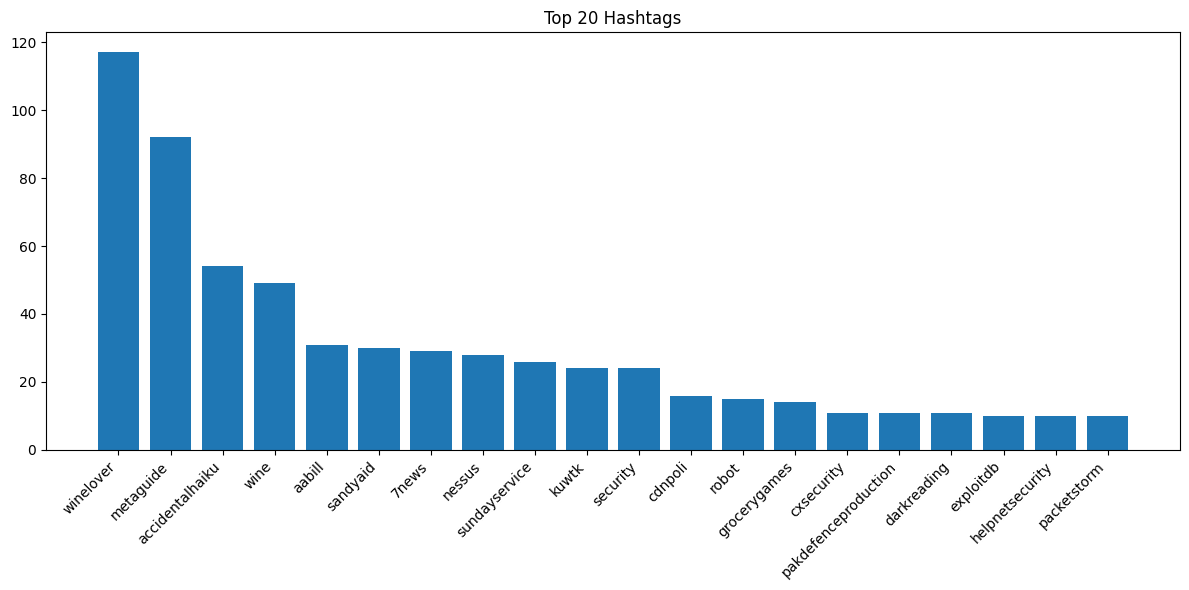

In [52]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import networkx as nx

# Antager at 'data' er jeres DataFrame og 'Hashtags' kolonnen allerede eksisterer

# Saml alle hashtags
# Først, lad os sikre os, at hashtags er i en liste-format
def ensure_list(hashtags):
    if isinstance(hashtags, list):
        return hashtags
    elif isinstance(hashtags, str):
        return hashtags.split(' ') 
    else:
        return []

data['hashtag_list'] = data['hashtags'].apply(ensure_list)

all_hashtags = [hashtag.lower().strip() for tweet in data['hashtag_list'] for hashtag in tweet if hashtag]

# Tæl frekvenser
hashtag_counts = Counter(all_hashtags)

# Filtrer og sortér
min_count = 10  # Juster efter behov
top_hashtags = {k: v for k, v in hashtag_counts.items() if v >= min_count}
sorted_hashtags = sorted(top_hashtags.items(), key=lambda x: x[1], reverse=True)

# Visualiser top hashtags
plt.figure(figsize=(12, 6))
plt.bar(*zip(*sorted_hashtags[:20]))
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Hashtags')
plt.tight_layout()
plt.show()

In [53]:
import pandas as pd
import networkx as nx
from collections import Counter
import itertools
import plotly.graph_objects as go

# Indlæs data - hvis data allerede er indlæst, så brug det eksisterende df (data)
# data = pd.read_csv('filtered_data.csv')  # Hvis du skal læse fra fil
# Antager, at data allerede er defineret i din session.

# Opret en graf
G = nx.Graph()

# Initialize dictionary to keep track of hashtag pairs (edges)
hashtag_pairs = Counter()

# Gennemgå tweets og find hashtags
for tweet in data['hashtags'].dropna():  # Fjern NaN-værdier
    hashtags = tweet.split()  # Del på mellemrum
    if len(hashtags) > 1:
        # Find alle par af hashtags i samme tweet og opdater tælleren
        for pair in itertools.combinations(hashtags, 2):
            hashtag_pairs[pair] += 1

# Tilføj noder og kanter til grafen
for pair, weight in hashtag_pairs.items():
    G.add_edge(pair[0], pair[1], weight=weight)

# Beregn centralitetsmål
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

# Visualisering
node_size = [20 + 100 * degree_centrality[node] for node in G.nodes]
pos = nx.spring_layout(G, k=1, iterations=50, seed=42)

# Edge positions og node positions
edge_x, edge_y = [], []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

node_x, node_y, node_text = [], [], []
for node in G.nodes:
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(
        f"Hashtag: {node}<br>"
        f"Degree Centrality: {degree_centrality[node]:.3f}<br>"
        f"Betweenness Centrality: {betweenness_centrality[node]:.3f}<br>"
        f"Eigenvector Centrality: {eigenvector_centrality[node]:.3f}"  # Tilføjet Eigenvector Centrality
    )

# Opret Plotly-figur
fig = go.Figure()

# Tilføj kanter
fig.add_trace(go.Scatter(
    x=edge_x,
    y=edge_y,
    mode='lines',
    line=dict(width=0.8, color='rgba(169,169,169,0.5)'),
    hoverinfo='none'
))

# Tilføj noder
fig.add_trace(go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    text=[node for node in G.nodes],
    textposition="top center",
    hovertext=node_text,  # Nu vises Eigenvector Centrality i hovertext
    hoverinfo='text',
    marker=dict(
        size=node_size,
        color=[degree_centrality[node] for node in G.nodes],
        colorscale='Viridis',
        line=dict(width=1, color='white'),
        showscale=True,
        colorbar=dict(title="Centrality")
    )
))

# Layout og interaktivitet
fig.update_layout(
    title="Hashtag Network",
    width=1200,
    height=1000,
    showlegend=False,
    hovermode='closest',
    plot_bgcolor='rgb(250,250,250)',
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
)

fig.show()


# Machine Learning